<a href="https://colab.research.google.com/github/dochinamu/Matrix-Factorization-Techniques-/blob/main/1_data_preprocess_ipynb%EC%9D%98%20%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Import required libraries
import os
import zipfile
from urllib.request import urlretrieve

# Define dataset URL and filename
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
filename = 'ml-100k.zip'

# Download the dataset
urlretrieve(url, filename)

# Unzip the downloaded file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

# Print confirmation message
print('MovieLens 100k dataset downloaded and unzipped!')

MovieLens 100k dataset downloaded and unzipped!


In [2]:
ratings = pd.read_csv(
    "./ml-100k/u.data",
    sep="\t",
    usecols=[0, 1, 2, 3],
    names=["user", "item", "rating", "time"],
)

In [3]:
ratings

,user,item,rating,time
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


기본 통계
* 유저, 아이템 수
* 유저별 평가 수 등..

In [4]:
ratings.groupby('user').agg({'item': len}).agg({'item':[min, max, np.mean, len]})

,item
min,20.000000
max,737.000000
mean,106.044539
len,943.000000


In [5]:
ratings.groupby('item').agg({'user': len}).agg({'user':[min, max, np.mean, len]})

,user
min,1.000000
max,583.000000
mean,59.453032
len,1682.000000


In [6]:
ratings.groupby('rating').agg({'item':len})

,item
rating,
1,6110
2,11370
3,27145
4,34174
5,21201


<Axes: xlabel='rating'>

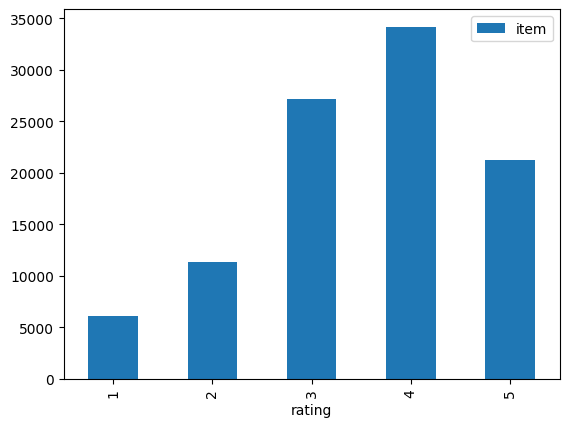

In [7]:
ratings.groupby('rating').agg({'item':len}).plot.bar()

전처리
* user, item 인덱스 0부터 가공
* explicit to implicit
* train, val, test => 8 1 1

In [8]:
unique_users = ratings['user'].unique()
unique_items = ratings['item'].unique()

In [9]:
user2id = {user: idx for idx, user in enumerate(unique_users)}
id2user = {idx: user for idx, user in enumerate(unique_users)}

item2id = {item: idx for idx, item in enumerate(unique_items)}
id2item = {idx: item for idx, item in enumerate(unique_items)}

ratings['user'] = ratings['user'].map(user2id)
ratings['item'] = ratings['item'].map(item2id)

ratings

,user,item,rating,time
0,0,0,3,881250949
1,1,1,3,891717742
2,2,2,1,878887116
3,3,3,2,880606923
4,4,4,1,886397596
...,...,...,...,...
99995,875,173,3,880175444
99996,708,247,5,879795543
99997,37,1004,1,874795795
99998,58,443,2,882399156


In [10]:
ratings.loc[:, 'rating'] = 1

In [11]:
ratings

,user,item,rating,time
0,0,0,1,881250949
1,1,1,1,891717742
2,2,2,1,878887116
3,3,3,1,880606923
4,4,4,1,886397596
...,...,...,...,...
99995,875,173,1,880175444
99996,708,247,1,879795543
99997,37,1004,1,874795795
99998,58,443,1,882399156


In [12]:
ratings_sorted = ratings.sort_values(by=['user', 'time'])

In [13]:
# 각 유저별로 train, validation, test 데이터로 분할 (8:1:1 비율)
train, temp = train_test_split(ratings_sorted, test_size=0.2, stratify=ratings_sorted['user'], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp['user'], random_state=42)

In [14]:
len(ratings_sorted[ratings_sorted['user']==1]), len(train[train['user']==1]), len(val[val['user']==1]), len(test[test['user']==1])

(92, 74, 9, 9)

저장

In [15]:
import pickle

In [18]:
result = {
    "train": train,
    "val" : val,
    "test" : test,
    "all_items": all_movies,
    "user2id" : user2id,
    "id2user" : id2user,
    "item2id" : item2id,
    "id2item" : id2item,
}

In [19]:
with open('ml-100k_splited.pkl', 'wb') as f:
    pickle.dump(result, f)

negative sampling 예시

In [17]:
all_movies = ratings['item'].unique()

users, items, labels = [], [], []

user_item_set = set(zip(train['user'], train['item']))

num_neg = 4

for u, i in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1)
    for _ in range(num_neg):
        neg_item = np.random.choice(all_movies)
        while (u, neg_item) in user_item_set:
            neg_item = np.random.choice(all_movies)
        users.append(u)
        items.append(neg_item)
        labels.append(0)

100%|██████████| 80000/80000 [00:05<00:00, 14869.49it/s]


In [20]:
list(zip(users, items, labels))

[(476, 78, 1),
 (476, 949, 0),
 (476, 1641, 0),
 (476, 1188, 0),
 (476, 204, 0),
 (192, 319, 1),
 (192, 966, 0),
 (192, 243, 0),
 (192, 1503, 0),
 (192, 1099, 0),
 (782, 1316, 1),
 (782, 695, 0),
 (782, 27, 0),
 (782, 1042, 0),
 (782, 475, 0),
 (720, 438, 1),
 (720, 335, 0),
 (720, 675, 0),
 (720, 465, 0),
 (720, 34, 0),
 (491, 386, 1),
 (491, 748, 0),
 (491, 248, 0),
 (491, 640, 0),
 (491, 1210, 0),
 (626, 22, 1),
 (626, 122, 0),
 (626, 557, 0),
 (626, 1630, 0),
 (626, 689, 0),
 (3, 797, 1),
 (3, 2, 0),
 (3, 746, 0),
 (3, 225, 0),
 (3, 1317, 0),
 (58, 504, 1),
 (58, 400, 0),
 (58, 1157, 0),
 (58, 263, 0),
 (58, 341, 0),
 (777, 191, 1),
 (777, 300, 0),
 (777, 767, 0),
 (777, 645, 0),
 (777, 1074, 0),
 (89, 571, 1),
 (89, 274, 0),
 (89, 1554, 0),
 (89, 1073, 0),
 (89, 850, 0),
 (143, 53, 1),
 (143, 1506, 0),
 (143, 1645, 0),
 (143, 69, 0),
 (143, 1188, 0),
 (826, 83, 1),
 (826, 1213, 0),
 (826, 753, 0),
 (826, 774, 0),
 (826, 1017, 0),
 (927, 135, 1),
 (927, 684, 0),
 (927, 624, 0),
 (9

In [22]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful